In [1]:
%load_ext autoreload
%autoreload 2
from gfbm import *
from gfbm.data_tools.datamodule import DataModule
from gfbm.models.alpha_diff import AlphaDiffGratin, AlphaDiff
from gfbm.layers.encoders import TrajsEncoderLSTM
from gfbm.training.callbacks import fBMPlotter
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor
import os
import warnings
import matplotlib.pyplot as plt

/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
desired_BS = 128*8
dl_params = {"batch_size":128,"num_workers":10}
#dl_params = {"batch_size":16,"num_workers":10}
ds_params = {
    "N":int(1e5),
    "dim":1,
    "noise":0,
    "vary_tau":False,
    "length_range":(10,100),
    "alpha_range":(0.1,1.9),
    "length_sampling":"linear"}
graph_info = {"degree":20,"edge_method":"uniform"}
export_path = "/home/hverdier/Gaia/hecat/hippo/models/fbm/"

In [3]:
dm = DataModule(dl_params=dl_params,ds_params=ds_params,graph_info=graph_info, validate_on_long=True)
dm.setup()
#example_data = dm.ds_train[0]

Prepare datasets
stage is None, strange...
Creating new train fBMTrajDataset, seed=0
seed_offset = 0


In [4]:
encoder = TrajsEncoderLSTM(latent_dim=12)
model_lstm = AlphaDiff(encoder=encoder,latent_dim=12, scales=["step_std"])
model_gratin = AlphaDiffGratin(latent_dim=12)

['step_std']
['step_std']


In [ ]:
# Pour l'invariance : (?)
# Entraîner jusqu'à L_max
# Couper les trajectoires par morceaux de maximum L_max
# Moyenner les vecteurs latents
# Youhou

In [5]:
model = model_gratin
#model = model_lstm
#model_name = "LSTM"
model_name = "back_normal_attention"
tb_logger = pl.loggers.TensorBoardLogger(
        save_dir=os.path.join(export_path, "tb_logs"),
        default_hp_metric=False,
        name=model_name,
        flush_secs=60,
        #log_graph=True,
    )

trainer = pl.Trainer(
    gpus=1,
    detect_anomaly=True,
    deterministic=False,
    logger=tb_logger,
    gradient_clip_val=1.0,
    flush_logs_every_n_steps=50,
    track_grad_norm=2,
    accumulate_grad_batches=desired_BS//dl_params["batch_size"],
    max_epochs=50,
    callbacks=[fBMPlotter(), LearningRateMonitor(logging_interval="epoch",log_momentum=True)],
    reload_dataloaders_every_n_epochs=1)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    trainer.fit(model,dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:61: LightningDeprecationWarning: Setting `Trainer(flush_logs_every_n_steps=50)` is deprecated in v1.5 and will be removed in v1.7. Please configure flushing in the logger instead.
  rank_zero_deprecation(


Prepare datasets
Creating new train fBMTrajDataset, seed=0
seed_offset = 0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                | Params
-------------------------------------------------------
0 | features_maker | TrajsFeaturesSimple | 0     
1 | encoder        | TrajsEncoder        | 125 K 
2 | invertible_net | InvertibleNet       | 24.6 K
-------------------------------------------------------
150 K     Trainable params
12        Non-trainable params
150 K     Total params
0.601     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]Validation dataloader
Prepare datasets
seed_offset = 0
Prepare datasets                                                           
Creating new train fBMTrajDataset, seed=0
seed_offset = 0
Train dataloader, epoch = 0
Epoch 0: 100%|██████████| 843/843 [02:59<00:00,  4.69it/s, loss=-2.36, v_num=1, training_loss_step=-1.90, z_norm=2.770, log_J=3.280, val_MSE_mean_log_diff=0.0892, val_MSE_mean_upper_log_diff=0.0824, val_MSE_log_diff=0.171, val_MSE_upper_log_diff=0.128, val_Var_log_diff=1.200, val_MSE_mean_alpha=0.179, val_MSE_mean_upper_alpha=0.275, val_MSE_alpha=0.254, val_MSE_upper_alpha=0.354, val_Var_alpha=0.245, training_loss_epoch=-1.21]Prepare datasets
Creating new train fBMTrajDataset, seed=100000
seed_offset = 100000
Train dataloader, epoch = 1
Epoch 1:  49%|████▉     | 412/843 [02:22<02:28,  2.90it/s, loss=-2.61, v_num=1, training_loss_step=-2.61, z_norm=1.890, log_J=3.560, val_MSE_mean_log_diff=0.0892, val_MSE_mean_upper_log_diff=0.0824, val_MS

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 1:  49%|████▉     | 414/843 [02:22<02:27,  2.90it/s, loss=-2.58, v_num=1, training_loss_step=-2.46, z_norm=2.230, log_J=3.570, val_MSE_mean_log_diff=0.0892, val_MSE_mean_upper_log_diff=0.0824, val_MSE_log_diff=0.171, val_MSE_upper_log_diff=0.128, val_Var_log_diff=1.200, val_MSE_mean_alpha=0.179, val_MSE_mean_upper_alpha=0.275, val_MSE_alpha=0.254, val_MSE_upper_alpha=0.354, val_Var_alpha=0.245, training_loss_epoch=-1.21]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 1:  49%|████▉     | 415/843 [02:22<02:27,  2.90it/s, loss=-2.6, v_num=1, training_loss_step=-2.70, z_norm=1.780, log_J=3.590, val_MSE_mean_log_diff=0.0892, val_MSE_mean_upper_log_diff=0.0824, val_MSE_log_diff=0.171, val_MSE_upper_log_diff=0.128, val_Var_log_diff=1.200, val_MSE_mean_alpha=0.179, val_MSE_mean_upper_alpha=0.275, val_MSE_alpha=0.254, val_MSE_upper_alpha=0.354, val_Var_alpha=0.245, training_loss_epoch=-1.21] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/p

Epoch 1:  49%|████▉     | 416/843 [02:23<02:27,  2.90it/s, loss=-2.61, v_num=1, training_loss_step=-2.58, z_norm=2.020, log_J=3.590, val_MSE_mean_log_diff=0.0892, val_MSE_mean_upper_log_diff=0.0824, val_MSE_log_diff=0.171, val_MSE_upper_log_diff=0.128, val_Var_log_diff=1.200, val_MSE_mean_alpha=0.179, val_MSE_mean_upper_alpha=0.275, val_MSE_alpha=0.254, val_MSE_upper_alpha=0.354, val_Var_alpha=0.245, training_loss_epoch=-1.21]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 1:  50%|████▉     | 419/843 [02:24<02:26,  2.90it/s, loss=-2.59, v_num=1, training_loss_step=-2.11, z_norm=3.070, log_J=3.650, val_MSE_mean_log_diff=0.0892, val_MSE_mean_upper_log_diff=0.0824, val_MSE_log_diff=0.171, val_MSE_upper_log_diff=0.128, val_Var_log_diff=1.200, val_MSE_mean_alpha=0.179, val_MSE_mean_upper_alpha=0.275, val_MSE_alpha=0.254, val_MSE_upper_alpha=0.354, val_Var_alpha=0.245, training_loss_epoch=-1.21]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/p

Epoch 1:  50%|████▉     | 420/843 [02:24<02:25,  2.90it/s, loss=-2.59, v_num=1, training_loss_step=-2.11, z_norm=3.070, log_J=3.650, val_MSE_mean_log_diff=0.0892, val_MSE_mean_upper_log_diff=0.0824, val_MSE_log_diff=0.171, val_MSE_upper_log_diff=0.128, val_Var_log_diff=1.200, val_MSE_mean_alpha=0.179, val_MSE_mean_upper_alpha=0.275, val_MSE_alpha=0.254, val_MSE_upper_alpha=0.354, val_Var_alpha=0.245, training_loss_epoch=-1.21]

    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    

Epoch 1:  50%|████▉     | 420/843 [02:24<02:25,  2.90it/s, loss=-2.57, v_num=1, training_loss_step=-2.50, z_norm=2.270, log_J=3.640, val_MSE_mean_log_diff=0.0892, val_MSE_mean_upper_log_diff=0.0824, val_MSE_log_diff=0.171, val_MSE_upper_log_diff=0.128, val_Var_log_diff=1.200, val_MSE_mean_alpha=0.179, val_MSE_mean_upper_alpha=0.275, val_MSE_alpha=0.254, val_MSE_upper_alpha=0.354, val_Var_alpha=0.245, training_loss_epoch=-1.21]

assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 1:  50%|████▉     | 421/843 [02:25<02:25,  2.90it/s, loss=-2.55, v_num=1, training_loss_step=-2.57, z_norm=2.060, log_J=3.600, val_MSE_mean_log_diff=0.0892, val_MSE_mean_upper_log_diff=0.0824, val_MSE_log_diff=0.171, val_MSE_upper_log_diff=0.128, val_Var_log_diff=1.200, val_MSE_mean_alpha=0.179, val_MSE_mean_upper_alpha=0.275, val_MSE_alpha=0.254, val_MSE_upper_alpha=0.354, val_Var_alpha=0.245, training_loss_epoch=-1.21]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 1:  63%|██████▎   | 533/843 [02:49<01:38,  3.15it/s, loss=-2.45, v_num=1, training_loss_step=-2.82, z_norm=1.700, log_J=3.670, val_MSE_mean_log_diff=0.0892, val_MSE_mean_upper_log_diff=0.0824, val_MSE_log_diff=0.171, val_MSE_upper_log_diff=0.128, val_Var_log_diff=1.200, val_MSE_mean_alpha=0.179, val_MSE_mean_upper_alpha=0.275, val_MSE_alpha=0.254, val_MSE_upper_alpha=0.354, val_Var_alpha=0.245, training_loss_epoch=-1.21]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 1:  64%|██████▎   | 537/843 [02:50<01:37,  3.15it/s, loss=-2.39, v_num=1, training_loss_step=-2.40, z_norm=2.610, log_J=3.700, val_MSE_mean_log_diff=0.0892, val_MSE_mean_upper_log_diff=0.0824, val_MSE_log_diff=0.171, val_MSE_upper_log_diff=0.128, val_Var_log_diff=1.200, val_MSE_mean_alpha=0.179, val_MSE_mean_upper_alpha=0.275, val_MSE_alpha=0.254, val_MSE_upper_alpha=0.354, val_Var_alpha=0.245, training_loss_epoch=-1.21]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()

Epoch 1:  64%|██████▍   | 538/843 [02:50<01:36,  3.15it/s, loss=-2.39, v_num=1, training_loss_step=-2.40, z_norm=2.610, log_J=3.700, val_MSE_mean_log_diff=0.0892, val_MSE_mean_upper_log_diff=0.0824, val_MSE_log_diff=0.171, val_MSE_upper_log_diff=0.128, val_Var_log_diff=1.200, val_MSE_mean_alpha=0.179, val_MSE_mean_upper_alpha=0.275, val_MSE_alpha=0.254, val_MSE_upper_alpha=0.354, val_Var_alpha=0.245, training_loss_epoch=-1.21]


  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process

Epoch 1:  64%|██████▍   | 538/843 [02:50<01:36,  3.15it/s, loss=-2.39, v_num=1, training_loss_step=-2.69, z_norm=1.930, log_J=3.660, val_MSE_mean_log_diff=0.0892, val_MSE_mean_upper_log_diff=0.0824, val_MSE_log_diff=0.171, val_MSE_upper_log_diff=0.128, val_Var_log_diff=1.200, val_MSE_mean_alpha=0.179, val_MSE_mean_upper_alpha=0.275, val_MSE_alpha=0.254, val_MSE_upper_alpha=0.354, val_Var_alpha=0.245, training_loss_epoch=-1.21]

Epoch 1:  93%|█████████▎| 781/843 [03:43<00:17,  3.50it/s, loss=-2.69, v_num=1, training_loss_step=-2.91, z_norm=1.300, log_J=3.560, val_MSE_mean_log_diff=0.0892, val_MSE_mean_upper_log_diff=0.0824, val_MSE_log_diff=0.171, val_MSE_upper_log_diff=0.128, val_Var_log_diff=1.200, val_MSE_mean_alpha=0.179, val_MSE_mean_upper_alpha=0.275, val_MSE_alpha=0.254, val_MSE_upper_alpha=0.354, val_Var_alpha=0.245, training_loss_epoch=-1.21]Validation dataloader
Prepare datasets
seed_offset = 0
Epoch 1: 100%|██████████| 843/843 [03:47<00:00,  3.70it/s, loss=-2.69, v_num=1, training_loss_step=-2.91, z_norm=1.300, log_J=3.560, val_MSE_mean_log_diff=0.190, val_MSE_mean_upper_log_diff=0.0943, val_MSE_log_diff=0.373, val_MSE_upper_log_diff=0.124, val_Var_log_diff=1.670, val_MSE_mean_alpha=0.0807, val_MSE_mean_upper_alpha=0.0962, val_MSE_alpha=0.145, val_MSE_upper_alpha=0.151, val_Var_alpha=0.192, training_loss_epoch=-2.51]Prepare datasets
Creating new train fBMTrajDataset, seed=200000
seed_offset = 200000

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 2:   5%|▌         | 43/843 [01:01<19:06,  1.43s/it, loss=-2.65, v_num=1, training_loss_step=-2.69, z_norm=1.890, log_J=3.640, val_MSE_mean_log_diff=0.190, val_MSE_mean_upper_log_diff=0.0943, val_MSE_log_diff=0.373, val_MSE_upper_log_diff=0.124, val_Var_log_diff=1.670, val_MSE_mean_alpha=0.0807, val_MSE_mean_upper_alpha=0.0962, val_MSE_alpha=0.145, val_MSE_upper_alpha=0.151, val_Var_alpha=0.192, training_loss_epoch=-2.51]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 2:   5%|▌         | 45/843 [01:02<18:20,  1.38s/it, loss=-2.66, v_num=1, training_loss_step=-2.48, z_norm=2.430, log_J=3.700, val_MSE_mean_log_diff=0.190, val_MSE_mean_upper_log_diff=0.0943, val_MSE_log_diff=0.373, val_MSE_upper_log_diff=0.124, val_Var_log_diff=1.670, val_MSE_mean_alpha=0.0807, val_MSE_mean_upper_alpha=0.0962, val_MSE_alpha=0.145, val_MSE_upper_alpha=0.151, val_Var_alpha=0.192, training_loss_epoch=-2.51]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 2:   6%|▌         | 47/843 [01:02<17:39,  1.33s/it, loss=-2.66, v_num=1, training_loss_step=-2.85, z_norm=1.690, log_J=3.700, val_MSE_mean_log_diff=0.190, val_MSE_mean_upper_log_diff=0.0943, val_MSE_log_diff=0.373, val_MSE_upper_log_diff=0.124, val_Var_log_diff=1.670, val_MSE_mean_alpha=0.0807, val_MSE_mean_upper_alpha=0.0962, val_MSE_alpha=0.145, val_MSE_upper_alpha=0.151, val_Var_alpha=0.192, training_loss_epoch=-2.51]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 2:   6%|▌         | 48/843 [01:02<17:21,  1.31s/it, loss=-2.67, v_num=1, training_loss_step=-2.89, z_norm=1.560, log_J=3.680, val_MSE_mean_log_diff=0.190, val_MSE_mean_upper_log_diff=0.0943, val_MSE_log_diff=0.373, val_MSE_upper_log_diff=0.124, val_Var_log_diff=1.670, val_MSE_mean_alpha=0.0807, val_MSE_mean_upper_alpha=0.0962, val_MSE_alpha=0.145, val_MSE_upper_alpha=0.151, val_Var_alpha=0.192, training_loss_epoch=-2.51]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 2:   6%|▌         | 49/843 [01:03<17:01,  1.29s/it, loss=-2.68, v_num=1, training_loss_step=-2.61, z_norm=1.970, log_J=3.590, val_MSE_mean_log_diff=0.190, val_MSE_mean_upper_log_diff=0.0943, val_MSE_log_diff=0.373, val_MSE_upper_log_diff=0.124, val_Var_log_diff=1.670, val_MSE_mean_alpha=0.0807, val_MSE_mean_upper_alpha=0.0962, val_MSE_alpha=0.145, val_MSE_upper_alpha=0.151, val_Var_alpha=0.192, training_loss_epoch=-2.51]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 2:   6%|▌         | 50/843 [01:03<16:43,  1.27s/it, loss=-2.66, v_num=1, training_loss_step=-1.91, z_norm=3.340, log_J=3.580, val_MSE_mean_log_diff=0.190, val_MSE_mean_upper_log_diff=0.0943, val_MSE_log_diff=0.373, val_MSE_upper_log_diff=0.124, val_Var_log_diff=1.670, val_MSE_mean_alpha=0.0807, val_MSE_mean_upper_alpha=0.0962, val_MSE_alpha=0.145, val_MSE_upper_alpha=0.151, val_Var_alpha=0.192, training_loss_epoch=-2.51]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 2:   6%|▌         | 51/843 [01:03<16:26,  1.25s/it, loss=-2.66, v_num=1, training_loss_step=-2.36, z_norm=2.370, log_J=3.550, val_MSE_mean_log_diff=0.190, val_MSE_mean_upper_log_diff=0.0943, val_MSE_log_diff=0.373, val_MSE_upper_log_diff=0.124, val_Var_log_diff=1.670, val_MSE_mean_alpha=0.0807, val_MSE_mean_upper_alpha=0.0962, val_MSE_alpha=0.145, val_MSE_upper_alpha=0.151, val_Var_alpha=0.192, training_loss_epoch=-2.51]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()


Epoch 2:   6%|▌         | 52/843 [01:03<16:09,  1.23s/it, loss=-2.66, v_num=1, training_loss_step=-2.36, z_norm=2.370, log_J=3.550, val_MSE_mean_log_diff=0.190, val_MSE_mean_upper_log_diff=0.0943, val_MSE_log_diff=0.373, val_MSE_upper_log_diff=0.124, val_Var_log_diff=1.670, val_MSE_mean_alpha=0.0807, val_MSE_mean_upper_alpha=0.0962, val_MSE_alpha=0.145, val_MSE_upper_alpha=0.151, val_Var_alpha=0.192, training_loss_epoch=-2.51]

  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers


Epoch 2:   6%|▌         | 52/843 [01:03<16:09,  1.23s/it, loss=-2.66, v_num=1, training_loss_step=-2.36, z_norm=2.370, log_J=3.550, val_MSE_mean_log_diff=0.190, val_MSE_mean_upper_log_diff=0.0943, val_MSE_log_diff=0.373, val_MSE_upper_log_diff=0.124, val_Var_log_diff=1.670, val_MSE_mean_alpha=0.0807, val_MSE_mean_upper_alpha=0.0962, val_MSE_alpha=0.145, val_MSE_upper_alpha=0.151, val_Var_alpha=0.192, training_loss_epoch=-2.51]

    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive


Epoch 2:   6%|▌         | 52/843 [01:03<16:09,  1.23s/it, loss=-2.66, v_num=1, training_loss_step=-2.86, z_norm=1.660, log_J=3.690, val_MSE_mean_log_diff=0.190, val_MSE_mean_upper_log_diff=0.0943, val_MSE_log_diff=0.373, val_MSE_upper_log_diff=0.124, val_Var_log_diff=1.670, val_MSE_mean_alpha=0.0807, val_MSE_mean_upper_alpha=0.0962, val_MSE_alpha=0.145, val_MSE_upper_alpha=0.151, val_Var_alpha=0.192, training_loss_epoch=-2.51]

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 2:   7%|▋         | 55/843 [01:04<15:22,  1.17s/it, loss=-2.67, v_num=1, training_loss_step=-2.94, z_norm=1.550, log_J=3.710, val_MSE_mean_log_diff=0.190, val_MSE_mean_upper_log_diff=0.0943, val_MSE_log_diff=0.373, val_MSE_upper_log_diff=0.124, val_Var_log_diff=1.670, val_MSE_mean_alpha=0.0807, val_MSE_mean_upper_alpha=0.0962, val_MSE_alpha=0.145, val_MSE_upper_alpha=0.151, val_Var_alpha=0.192, training_loss_epoch=-2.51]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 2:   7%|▋         | 56/843 [01:04<15:09,  1.16s/it, loss=-2.67, v_num=1, training_loss_step=-2.76, z_norm=1.940, log_J=3.730, val_MSE_mean_log_diff=0.190, val_MSE_mean_upper_log_diff=0.0943, val_MSE_log_diff=0.373, val_MSE_upper_log_diff=0.124, val_Var_log_diff=1.670, val_MSE_mean_alpha=0.0807, val_MSE_mean_upper_alpha=0.0962, val_MSE_alpha=0.145, val_MSE_upper_alpha=0.151, val_Var_alpha=0.192, training_loss_epoch=-2.51]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 2:  93%|█████████▎| 781/843 [03:43<00:17,  3.49it/s, loss=-2.7, v_num=1, training_loss_step=-2.85, z_norm=1.710, log_J=3.700, val_MSE_mean_log_diff=0.190, val_MSE_mean_upper_log_diff=0.0943, val_MSE_log_diff=0.373, val_MSE_upper_log_diff=0.124, val_Var_log_diff=1.670, val_MSE_mean_alpha=0.0807, val_MSE_mean_upper_alpha=0.0962, val_MSE_alpha=0.145, val_MSE_upper_alpha=0.151, val_Var_alpha=0.192, training_loss_epoch=-2.51] Validation dataloader
Prepare datasets
seed_offset = 0
Epoch 2: 100%|██████████| 843/843 [03:48<00:00,  3.69it/s, loss=-2.7, v_num=1, training_loss_step=-2.85, z_norm=1.710, log_J=3.700, val_MSE_mean_log_diff=0.0359, val_MSE_mean_upper_log_diff=0.0304, val_MSE_log_diff=0.0653, val_MSE_upper_log_diff=0.0617, val_Var_log_diff=1.360, val_MSE_mean_alpha=0.0581, val_MSE_mean_upper_alpha=0.053, val_MSE_alpha=0.105, val_MSE_upper_alpha=0.0988, val_Var_alpha=0.140, training_loss_epoch=-2.62]Prepare datasets
Creating new train fBMTrajDataset, seed=300000
seed_offset = 300

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 3:  23%|██▎       | 192/843 [01:30<05:07,  2.12it/s, loss=-2.15, v_num=1, training_loss_step=-1.36, z_norm=4.680, log_J=3.700, val_MSE_mean_log_diff=0.0359, val_MSE_mean_upper_log_diff=0.0304, val_MSE_log_diff=0.0653, val_MSE_upper_log_diff=0.0617, val_Var_log_diff=1.360, val_MSE_mean_alpha=0.0581, val_MSE_mean_upper_alpha=0.053, val_MSE_alpha=0.105, val_MSE_upper_alpha=0.0988, val_Var_alpha=0.140, training_loss_epoch=-2.62]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 3:  23%|██▎       | 193/843 [01:30<05:05,  2.13it/s, loss=-2.22, v_num=1, training_loss_step=-2.74, z_norm=2.050, log_J=3.770, val_MSE_mean_log_diff=0.0359, val_MSE_mean_upper_log_diff=0.0304, val_MSE_log_diff=0.0653, val_MSE_upper_log_diff=0.0617, val_Var_log_diff=1.360, val_MSE_mean_alpha=0.0581, val_MSE_mean_upper_alpha=0.053, val_MSE_alpha=0.105, val_MSE_upper_alpha=0.0988, val_Var_alpha=0.140, training_loss_epoch=-2.62]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 3:  23%|██▎       | 194/843 [01:31<05:04,  2.13it/s, loss=-2.19, v_num=1, training_loss_step=-2.41, z_norm=2.630, log_J=3.720, val_MSE_mean_log_diff=0.0359, val_MSE_mean_upper_log_diff=0.0304, val_MSE_log_diff=0.0653, val_MSE_upper_log_diff=0.0617, val_Var_log_diff=1.360, val_MSE_mean_alpha=0.0581, val_MSE_mean_upper_alpha=0.053, val_MSE_alpha=0.105, val_MSE_upper_alpha=0.0988, val_Var_alpha=0.140, training_loss_epoch=-2.62]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 3:  23%|██▎       | 195/843 [01:31<05:03,  2.14it/s, loss=-2.19, v_num=1, training_loss_step=-2.82, z_norm=1.910, log_J=3.770, val_MSE_mean_log_diff=0.0359, val_MSE_mean_upper_log_diff=0.0304, val_MSE_log_diff=0.0653, val_MSE_upper_log_diff=0.0617, val_Var_log_diff=1.360, val_MSE_mean_alpha=0.0581, val_MSE_mean_upper_alpha=0.053, val_MSE_alpha=0.105, val_MSE_upper_alpha=0.0988, val_Var_alpha=0.140, training_loss_epoch=-2.62]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorcan only test a child process: 


Epoch 3:  23%|██▎       | 196/843 [01:31<05:02,  2.14it/s, loss=-2.18, v_num=1, training_loss_step=-2.83, z_norm=1.980, log_J=3.820, val_MSE_mean_log_diff=0.0359, val_MSE_mean_upper_log_diff=0.0304, val_MSE_log_diff=0.0653, val_MSE_upper_log_diff=0.0617, val_Var_log_diff=1.360, val_MSE_mean_alpha=0.0581, val_MSE_mean_upper_alpha=0.053, val_MSE_alpha=0.105, val_MSE_upper_alpha=0.0988, val_Var_alpha=0.140, training_loss_epoch=-2.62]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 3:  23%|██▎       | 197/843 [01:31<05:00,  2.15it/s, loss=-2.16, v_num=1, training_loss_step=-2.31, z_norm=2.970, log_J=3.800, val_MSE_mean_log_diff=0.0359, val_MSE_mean_upper_log_diff=0.0304, val_MSE_log_diff=0.0653, val_MSE_upper_log_diff=0.0617, val_Var_log_diff=1.360, val_MSE_mean_alpha=0.0581, val_MSE_mean_upper_alpha=0.053, val_MSE_alpha=0.105, val_MSE_upper_alpha=0.0988, val_Var_alpha=0.140, training_loss_epoch=-2.62]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorcan only test a child process: 


Epoch 3:  23%|██▎       | 198/843 [01:31<04:59,  2.15it/s, loss=-2.2, v_num=1, training_loss_step=-2.15, z_norm=3.060, log_J=3.680, val_MSE_mean_log_diff=0.0359, val_MSE_mean_upper_log_diff=0.0304, val_MSE_log_diff=0.0653, val_MSE_upper_log_diff=0.0617, val_Var_log_diff=1.360, val_MSE_mean_alpha=0.0581, val_MSE_mean_upper_alpha=0.053, val_MSE_alpha=0.105, val_MSE_upper_alpha=0.0988, val_Var_alpha=0.140, training_loss_epoch=-2.62] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 3:  24%|██▎       | 199/843 [01:32<04:58,  2.16it/s, loss=-2.37, v_num=1, training_loss_step=-3.07, z_norm=1.530, log_J=3.840, val_MSE_mean_log_diff=0.0359, val_MSE_mean_upper_log_diff=0.0304, val_MSE_log_diff=0.0653, val_MSE_upper_log_diff=0.0617, val_Var_log_diff=1.360, val_MSE_mean_alpha=0.0581, val_MSE_mean_upper_alpha=0.053, val_MSE_alpha=0.105, val_MSE_upper_alpha=0.0988, val_Var_alpha=0.140, training_loss_epoch=-2.62]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>

Epoch 3:  24%|██▎       | 200/843 [01:32<04:57,  2.16it/s, loss=-2.37, v_num=1, training_loss_step=-3.07, z_norm=1.530, log_J=3.840, val_MSE_mean_log_diff=0.0359, val_MSE_mean_upper_log_diff=0.0304, val_MSE_log_diff=0.0653, val_MSE_upper_log_diff=0.0617, val_Var_log_diff=1.360, val_MSE_mean_alpha=0.0581, val_MSE_mean_upper_alpha=0.053, val_MSE_alpha=0.105, val_MSE_upper_alpha=0.0988, val_Var_alpha=0.140, training_loss_epoch=-2.62]

Epoch 3:  24%|██▎       | 200/843 [01:32<04:57,  2.16it/s, loss=-2.37, v_num=1, training_loss_step=-3.07, z_norm=1.530, log_J=3.840, val_MSE_mean_log_diff=0.0359, val_MSE_mean_upper_log_diff=0.0304, val_MSE_log_diff=0.0653, val_MSE_upper_log_diff=0.0617, val_Var_log_diff=1.360, val_MSE_mean_alpha=0.0581, val_MSE_mean_upper_alpha=0.053, val_MSE_alpha=0.105, val_MSE_upper_alpha=0.0988, val_Var_alpha=0.140, training_loss_epoch=-2.62]

Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers


Epoch 3:  24%|██▎       | 200/843 [01:32<04:57,  2.16it/s, loss=-2.39, v_num=1, training_loss_step=-2.95, z_norm=1.750, log_J=3.830, val_MSE_mean_log_diff=0.0359, val_MSE_mean_upper_log_diff=0.0304, val_MSE_log_diff=0.0653, val_MSE_upper_log_diff=0.0617, val_Var_log_diff=1.360, val_MSE_mean_alpha=0.0581, val_MSE_mean_upper_alpha=0.053, val_MSE_alpha=0.105, val_MSE_upper_alpha=0.0988, val_Var_alpha=0.140, training_loss_epoch=-2.62]

    
if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'AssertionError: can only test a child process


Epoch 3:  93%|█████████▎| 781/843 [03:39<00:17,  3.56it/s, loss=-2.69, v_num=1, training_loss_step=-2.86, z_norm=1.820, log_J=3.770, val_MSE_mean_log_diff=0.0359, val_MSE_mean_upper_log_diff=0.0304, val_MSE_log_diff=0.0653, val_MSE_upper_log_diff=0.0617, val_Var_log_diff=1.360, val_MSE_mean_alpha=0.0581, val_MSE_mean_upper_alpha=0.053, val_MSE_alpha=0.105, val_MSE_upper_alpha=0.0988, val_Var_alpha=0.140, training_loss_epoch=-2.62]Validation dataloader
Prepare datasets
seed_offset = 0
Epoch 3: 100%|██████████| 843/843 [03:44<00:00,  3.76it/s, loss=-2.69, v_num=1, training_loss_step=-2.86, z_norm=1.820, log_J=3.770, val_MSE_mean_log_diff=0.0704, val_MSE_mean_upper_log_diff=0.0456, val_MSE_log_diff=0.0992, val_MSE_upper_log_diff=0.0742, val_Var_log_diff=1.470, val_MSE_mean_alpha=0.056, val_MSE_mean_upper_alpha=0.0627, val_MSE_alpha=0.0958, val_MSE_upper_alpha=0.104, val_Var_alpha=0.144, training_loss_epoch=-2.70]Prepare datasets
Creating new train fBMTrajDataset, seed=400000
seed_offset =

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
      File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 5:  21%|██        | 173/843 [01:25<05:32,  2.01it/s, loss=-2.91, v_num=1, training_loss_step=-2.89, z_norm=2.040, log_J=3.910, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0168, val_MSE_log_diff=0.0441, val_MSE_upper_log_diff=0.0436, val_Var_log_diff=1.320, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.065, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.109, val_Var_alpha=0.132, training_loss_epoch=-2.75]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 5:  21%|██        | 174/843 [01:26<05:31,  2.02it/s, loss=-2.9, v_num=1, training_loss_step=-2.92, z_norm=1.890, log_J=3.870, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0168, val_MSE_log_diff=0.0441, val_MSE_upper_log_diff=0.0436, val_Var_log_diff=1.320, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.065, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.109, val_Var_alpha=0.132, training_loss_epoch=-2.75] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 5:  21%|██        | 175/843 [01:26<05:29,  2.02it/s, loss=-2.89, v_num=1, training_loss_step=-2.62, z_norm=2.570, log_J=3.900, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0168, val_MSE_log_diff=0.0441, val_MSE_upper_log_diff=0.0436, val_Var_log_diff=1.320, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.065, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.109, val_Var_alpha=0.132, training_loss_epoch=-2.75]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/p

Epoch 5:  21%|██        | 176/843 [01:26<05:28,  2.03it/s, loss=-2.86, v_num=1, training_loss_step=-2.54, z_norm=2.760, log_J=3.920, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0168, val_MSE_log_diff=0.0441, val_MSE_upper_log_diff=0.0436, val_Var_log_diff=1.320, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.065, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.109, val_Var_alpha=0.132, training_loss_epoch=-2.75]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 5:  21%|██        | 178/843 [01:27<05:25,  2.04it/s, loss=-2.88, v_num=1, training_loss_step=-3.12, z_norm=1.480, log_J=3.860, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0168, val_MSE_log_diff=0.0441, val_MSE_upper_log_diff=0.0436, val_Var_log_diff=1.320, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.065, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.109, val_Var_alpha=0.132, training_loss_epoch=-2.75]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 5:  21%|██        | 179/843 [01:27<05:24,  2.05it/s, loss=-2.88, v_num=1, training_loss_step=-2.93, z_norm=1.850, log_J=3.850, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0168, val_MSE_log_diff=0.0441, val_MSE_upper_log_diff=0.0436, val_Var_log_diff=1.320, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.065, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.109, val_Var_alpha=0.132, training_loss_epoch=-2.75]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/p

Epoch 5:  21%|██▏       | 181/843 [01:27<05:21,  2.06it/s, loss=-2.89, v_num=1, training_loss_step=-2.77, z_norm=2.140, log_J=3.840, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0168, val_MSE_log_diff=0.0441, val_MSE_upper_log_diff=0.0436, val_Var_log_diff=1.320, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.065, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.109, val_Var_alpha=0.132, training_loss_epoch=-2.75]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 5:  93%|█████████▎| 781/843 [03:39<00:17,  3.56it/s, loss=-2.93, v_num=1, training_loss_step=-3.06, z_norm=1.700, log_J=3.910, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0168, val_MSE_log_diff=0.0441, val_MSE_upper_log_diff=0.0436, val_Var_log_diff=1.320, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.065, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.109, val_Var_alpha=0.132, training_loss_epoch=-2.75]Validation dataloader
Prepare datasets
seed_offset = 0
Epoch 5: 100%|██████████| 843/843 [03:43<00:00,  3.77it/s, loss=-2.93, v_num=1, training_loss_step=-3.06, z_norm=1.700, log_J=3.910, val_MSE_mean_log_diff=0.0304, val_MSE_mean_upper_log_diff=0.0351, val_MSE_log_diff=0.0492, val_MSE_upper_log_diff=0.053, val_Var_log_diff=1.170, val_MSE_mean_alpha=0.064, val_MSE_mean_upper_alpha=0.0613, val_MSE_alpha=0.106, val_MSE_upper_alpha=0.103, val_Var_alpha=0.143, training_loss_epoch=-2.87] Prepare datasets
Creating new train fBMTrajDataset, seed=600000
seed_offset = 6

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>self._shutdown_workers()
Traceback (most recent call last):
Exception ignored in: 
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>Exception ignored in: 
        Traceback (most recent call last):
self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-pack

Epoch 6:  93%|█████████▎| 781/843 [02:53<00:13,  4.50it/s, loss=-2.98, v_num=1, training_loss_step=-3.01, z_norm=1.940, log_J=3.980, val_MSE_mean_log_diff=0.0304, val_MSE_mean_upper_log_diff=0.0351, val_MSE_log_diff=0.0492, val_MSE_upper_log_diff=0.053, val_Var_log_diff=1.170, val_MSE_mean_alpha=0.064, val_MSE_mean_upper_alpha=0.0613, val_MSE_alpha=0.106, val_MSE_upper_alpha=0.103, val_Var_alpha=0.143, training_loss_epoch=-2.87]Validation dataloader
Prepare datasets
seed_offset = 0
Epoch 6: 100%|██████████| 843/843 [02:58<00:00,  4.72it/s, loss=-2.98, v_num=1, training_loss_step=-3.01, z_norm=1.940, log_J=3.980, val_MSE_mean_log_diff=0.0305, val_MSE_mean_upper_log_diff=0.0282, val_MSE_log_diff=0.0513, val_MSE_upper_log_diff=0.0458, val_Var_log_diff=1.250, val_MSE_mean_alpha=0.064, val_MSE_mean_upper_alpha=0.0696, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.110, val_Var_alpha=0.143, training_loss_epoch=-2.91]Prepare datasets
Creating new train fBMTrajDataset, seed=700000
seed_offset = 70

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 7:  30%|██▉       | 252/843 [01:43<04:02,  2.44it/s, loss=-3.13, v_num=1, training_loss_step=-2.96, z_norm=2.040, log_J=3.980, val_MSE_mean_log_diff=0.0305, val_MSE_mean_upper_log_diff=0.0282, val_MSE_log_diff=0.0513, val_MSE_upper_log_diff=0.0458, val_Var_log_diff=1.250, val_MSE_mean_alpha=0.064, val_MSE_mean_upper_alpha=0.0696, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.110, val_Var_alpha=0.143, training_loss_epoch=-2.91]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 7:  30%|███       | 253/843 [01:43<04:01,  2.44it/s, loss=-3.14, v_num=1, training_loss_step=-3.17, z_norm=1.630, log_J=3.990, val_MSE_mean_log_diff=0.0305, val_MSE_mean_upper_log_diff=0.0282, val_MSE_log_diff=0.0513, val_MSE_upper_log_diff=0.0458, val_Var_log_diff=1.250, val_MSE_mean_alpha=0.064, val_MSE_mean_upper_alpha=0.0696, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.110, val_Var_alpha=0.143, training_loss_epoch=-2.91]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 7:  30%|███       | 254/843 [01:43<04:00,  2.45it/s, loss=-3.13, v_num=1, training_loss_step=-3.15, z_norm=1.710, log_J=4.000, val_MSE_mean_log_diff=0.0305, val_MSE_mean_upper_log_diff=0.0282, val_MSE_log_diff=0.0513, val_MSE_upper_log_diff=0.0458, val_Var_log_diff=1.250, val_MSE_mean_alpha=0.064, val_MSE_mean_upper_alpha=0.0696, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.110, val_Var_alpha=0.143, training_loss_epoch=-2.91]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 7:  30%|███       | 255/843 [01:44<03:59,  2.45it/s, loss=-3.12, v_num=1, training_loss_step=-2.76, z_norm=2.630, log_J=4.070, val_MSE_mean_log_diff=0.0305, val_MSE_mean_upper_log_diff=0.0282, val_MSE_log_diff=0.0513, val_MSE_upper_log_diff=0.0458, val_Var_log_diff=1.250, val_MSE_mean_alpha=0.064, val_MSE_mean_upper_alpha=0.0696, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.110, val_Var_alpha=0.143, training_loss_epoch=-2.91]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 7:  30%|███       | 256/843 [01:44<03:59,  2.45it/s, loss=-3.1, v_num=1, training_loss_step=-2.93, z_norm=2.080, log_J=3.970, val_MSE_mean_log_diff=0.0305, val_MSE_mean_upper_log_diff=0.0282, val_MSE_log_diff=0.0513, val_MSE_upper_log_diff=0.0458, val_Var_log_diff=1.250, val_MSE_mean_alpha=0.064, val_MSE_mean_upper_alpha=0.0696, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.110, val_Var_alpha=0.143, training_loss_epoch=-2.91] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 7:  30%|███       | 257/843 [01:44<03:58,  2.46it/s, loss=-3.1, v_num=1, training_loss_step=-3.16, z_norm=1.660, log_J=3.990, val_MSE_mean_log_diff=0.0305, val_MSE_mean_upper_log_diff=0.0282, val_MSE_log_diff=0.0513, val_MSE_upper_log_diff=0.0458, val_Var_log_diff=1.250, val_MSE_mean_alpha=0.064, val_MSE_mean_upper_alpha=0.0696, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.110, val_Var_alpha=0.143, training_loss_epoch=-2.91]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 7:  31%|███       | 258/843 [01:44<03:57,  2.46it/s, loss=-3.09, v_num=1, training_loss_step=-2.91, z_norm=2.120, log_J=3.970, val_MSE_mean_log_diff=0.0305, val_MSE_mean_upper_log_diff=0.0282, val_MSE_log_diff=0.0513, val_MSE_upper_log_diff=0.0458, val_Var_log_diff=1.250, val_MSE_mean_alpha=0.064, val_MSE_mean_upper_alpha=0.0696, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.110, val_Var_alpha=0.143, training_loss_epoch=-2.91]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 7:  31%|███       | 259/843 [01:44<03:56,  2.47it/s, loss=-3.08, v_num=1, training_loss_step=-3.04, z_norm=1.920, log_J=4.000, val_MSE_mean_log_diff=0.0305, val_MSE_mean_upper_log_diff=0.0282, val_MSE_log_diff=0.0513, val_MSE_upper_log_diff=0.0458, val_Var_log_diff=1.250, val_MSE_mean_alpha=0.064, val_MSE_mean_upper_alpha=0.0696, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.110, val_Var_alpha=0.143, training_loss_epoch=-2.91]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 7:  31%|███       | 260/843 [01:45<03:55,  2.47it/s, loss=-3.07, v_num=1, training_loss_step=-3.05, z_norm=1.950, log_J=4.020, val_MSE_mean_log_diff=0.0305, val_MSE_mean_upper_log_diff=0.0282, val_MSE_log_diff=0.0513, val_MSE_upper_log_diff=0.0458, val_Var_log_diff=1.250, val_MSE_mean_alpha=0.064, val_MSE_mean_upper_alpha=0.0696, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.110, val_Var_alpha=0.143, training_loss_epoch=-2.91]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 7:  93%|█████████▎| 781/843 [03:38<00:17,  3.57it/s, loss=-3.07, v_num=1, training_loss_step=-3.05, z_norm=1.950, log_J=4.030, val_MSE_mean_log_diff=0.0305, val_MSE_mean_upper_log_diff=0.0282, val_MSE_log_diff=0.0513, val_MSE_upper_log_diff=0.0458, val_Var_log_diff=1.250, val_MSE_mean_alpha=0.064, val_MSE_mean_upper_alpha=0.0696, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.110, val_Var_alpha=0.143, training_loss_epoch=-2.91]Validation dataloader
Prepare datasets
seed_offset = 0
Epoch 7: 100%|██████████| 843/843 [03:43<00:00,  3.77it/s, loss=-3.07, v_num=1, training_loss_step=-3.05, z_norm=1.950, log_J=4.030, val_MSE_mean_log_diff=0.0211, val_MSE_mean_upper_log_diff=0.0165, val_MSE_log_diff=0.0419, val_MSE_upper_log_diff=0.0352, val_Var_log_diff=1.330, val_MSE_mean_alpha=0.0519, val_MSE_mean_upper_alpha=0.0524, val_MSE_alpha=0.0926, val_MSE_upper_alpha=0.0964, val_Var_alpha=0.144, training_loss_epoch=-3.01]Prepare datasets
Creating new train fBMTrajDataset, seed=800000
seed_offset 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 8:  10%|▉         | 83/843 [00:19<02:58,  4.25it/s, loss=-2.9, v_num=1, training_loss_step=-2.01, z_norm=4.270, log_J=4.140, val_MSE_mean_log_diff=0.0211, val_MSE_mean_upper_log_diff=0.0165, val_MSE_log_diff=0.0419, val_MSE_upper_log_diff=0.0352, val_Var_log_diff=1.330, val_MSE_mean_alpha=0.0519, val_MSE_mean_upper_alpha=0.0524, val_MSE_alpha=0.0926, val_MSE_upper_alpha=0.0964, val_Var_alpha=0.144, training_loss_epoch=-3.01] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorcan only test a child process: 


Epoch 8:  10%|▉         | 84/843 [00:19<02:58,  4.25it/s, loss=-2.89, v_num=1, training_loss_step=-2.73, z_norm=2.760, log_J=4.120, val_MSE_mean_log_diff=0.0211, val_MSE_mean_upper_log_diff=0.0165, val_MSE_log_diff=0.0419, val_MSE_upper_log_diff=0.0352, val_Var_log_diff=1.330, val_MSE_mean_alpha=0.0519, val_MSE_mean_upper_alpha=0.0524, val_MSE_alpha=0.0926, val_MSE_upper_alpha=0.0964, val_Var_alpha=0.144, training_loss_epoch=-3.01]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 8:  10%|█         | 85/843 [00:19<02:58,  4.25it/s, loss=-2.88, v_num=1, training_loss_step=-2.88, z_norm=2.550, log_J=4.150, val_MSE_mean_log_diff=0.0211, val_MSE_mean_upper_log_diff=0.0165, val_MSE_log_diff=0.0419, val_MSE_upper_log_diff=0.0352, val_Var_log_diff=1.330, val_MSE_mean_alpha=0.0519, val_MSE_mean_upper_alpha=0.0524, val_MSE_alpha=0.0926, val_MSE_upper_alpha=0.0964, val_Var_alpha=0.144, training_loss_epoch=-3.01]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 8:  10%|█         | 86/843 [00:20<02:58,  4.25it/s, loss=-2.91, v_num=1, training_loss_step=-3.10, z_norm=1.940, log_J=4.070, val_MSE_mean_log_diff=0.0211, val_MSE_mean_upper_log_diff=0.0165, val_MSE_log_diff=0.0419, val_MSE_upper_log_diff=0.0352, val_Var_log_diff=1.330, val_MSE_mean_alpha=0.0519, val_MSE_mean_upper_alpha=0.0524, val_MSE_alpha=0.0926, val_MSE_upper_alpha=0.0964, val_Var_alpha=0.144, training_loss_epoch=-3.01]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 8:  10%|█         | 87/843 [00:20<02:57,  4.25it/s, loss=-2.9, v_num=1, training_loss_step=-2.77, z_norm=2.650, log_J=4.100, val_MSE_mean_log_diff=0.0211, val_MSE_mean_upper_log_diff=0.0165, val_MSE_log_diff=0.0419, val_MSE_upper_log_diff=0.0352, val_Var_log_diff=1.330, val_MSE_mean_alpha=0.0519, val_MSE_mean_upper_alpha=0.0524, val_MSE_alpha=0.0926, val_MSE_upper_alpha=0.0964, val_Var_alpha=0.144, training_loss_epoch=-3.01] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/p

Epoch 8:  10%|█         | 88/843 [00:20<02:58,  4.23it/s, loss=-2.9, v_num=1, training_loss_step=-3.05, z_norm=2.080, log_J=4.090, val_MSE_mean_log_diff=0.0211, val_MSE_mean_upper_log_diff=0.0165, val_MSE_log_diff=0.0419, val_MSE_upper_log_diff=0.0352, val_Var_log_diff=1.330, val_MSE_mean_alpha=0.0519, val_MSE_mean_upper_alpha=0.0524, val_MSE_alpha=0.0926, val_MSE_upper_alpha=0.0964, val_Var_alpha=0.144, training_loss_epoch=-3.01]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 8:  11%|█         | 90/843 [00:21<02:57,  4.24it/s, loss=-2.91, v_num=1, training_loss_step=-2.93, z_norm=2.340, log_J=4.100, val_MSE_mean_log_diff=0.0211, val_MSE_mean_upper_log_diff=0.0165, val_MSE_log_diff=0.0419, val_MSE_upper_log_diff=0.0352, val_Var_log_diff=1.330, val_MSE_mean_alpha=0.0519, val_MSE_mean_upper_alpha=0.0524, val_MSE_alpha=0.0926, val_MSE_upper_alpha=0.0964, val_Var_alpha=0.144, training_loss_epoch=-3.01]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/p

Epoch 8:  93%|█████████▎| 781/843 [02:52<00:13,  4.52it/s, loss=-3.01, v_num=1, training_loss_step=-3.11, z_norm=1.960, log_J=4.090, val_MSE_mean_log_diff=0.0211, val_MSE_mean_upper_log_diff=0.0165, val_MSE_log_diff=0.0419, val_MSE_upper_log_diff=0.0352, val_Var_log_diff=1.330, val_MSE_mean_alpha=0.0519, val_MSE_mean_upper_alpha=0.0524, val_MSE_alpha=0.0926, val_MSE_upper_alpha=0.0964, val_Var_alpha=0.144, training_loss_epoch=-3.01]Validation dataloader
Prepare datasets
seed_offset = 0
Epoch 8: 100%|██████████| 843/843 [02:57<00:00,  4.74it/s, loss=-3.01, v_num=1, training_loss_step=-3.11, z_norm=1.960, log_J=4.090, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0179, val_MSE_log_diff=0.0413, val_MSE_upper_log_diff=0.0361, val_Var_log_diff=1.390, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.0925, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.133, val_Var_alpha=0.150, training_loss_epoch=-3.03]  Prepare datasets
Creating new train fBMTrajDataset, seed=900000
seed_offs

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 9:  49%|████▉     | 414/843 [02:22<02:27,  2.90it/s, loss=-3.09, v_num=1, training_loss_step=-3.24, z_norm=1.650, log_J=4.070, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0179, val_MSE_log_diff=0.0413, val_MSE_upper_log_diff=0.0361, val_Var_log_diff=1.390, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.0925, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.133, val_Var_alpha=0.150, training_loss_epoch=-3.03]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 9:  49%|████▉     | 415/843 [02:23<02:27,  2.90it/s, loss=-3.09, v_num=1, training_loss_step=-3.03, z_norm=1.940, log_J=4.010, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0179, val_MSE_log_diff=0.0413, val_MSE_upper_log_diff=0.0361, val_Var_log_diff=1.390, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.0925, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.133, val_Var_alpha=0.150, training_loss_epoch=-3.03]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 9:  49%|████▉     | 417/843 [02:23<02:26,  2.91it/s, loss=-3.07, v_num=1, training_loss_step=-3.03, z_norm=1.950, log_J=4.000, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0179, val_MSE_log_diff=0.0413, val_MSE_upper_log_diff=0.0361, val_Var_log_diff=1.390, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.0925, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.133, val_Var_alpha=0.150, training_loss_epoch=-3.03]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 9:  50%|████▉     | 419/843 [02:23<02:25,  2.91it/s, loss=-3.1, v_num=1, training_loss_step=-3.29, z_norm=1.630, log_J=4.110, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0179, val_MSE_log_diff=0.0413, val_MSE_upper_log_diff=0.0361, val_Var_log_diff=1.390, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.0925, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.133, val_Var_alpha=0.150, training_loss_epoch=-3.03] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 9:  50%|████▉     | 420/843 [02:24<02:25,  2.91it/s, loss=-3.1, v_num=1, training_loss_step=-3.00, z_norm=2.200, log_J=4.100, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0179, val_MSE_log_diff=0.0413, val_MSE_upper_log_diff=0.0361, val_Var_log_diff=1.390, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.0925, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.133, val_Var_alpha=0.150, training_loss_epoch=-3.03]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 9:  50%|████▉     | 421/843 [02:24<02:24,  2.91it/s, loss=-3.1, v_num=1, training_loss_step=-3.19, z_norm=1.820, log_J=4.100, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0179, val_MSE_log_diff=0.0413, val_MSE_upper_log_diff=0.0361, val_Var_log_diff=1.390, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.0925, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.133, val_Var_alpha=0.150, training_loss_epoch=-3.03]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 9:  51%|█████     | 431/843 [02:26<02:20,  2.94it/s, loss=-3.12, v_num=1, training_loss_step=-3.24, z_norm=1.690, log_J=4.090, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0179, val_MSE_log_diff=0.0413, val_MSE_upper_log_diff=0.0361, val_Var_log_diff=1.390, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.0925, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.133, val_Var_alpha=0.150, training_loss_epoch=-3.03]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 9:  51%|█████▏    | 434/843 [02:27<02:18,  2.94it/s, loss=-3.11, v_num=1, training_loss_step=-3.07, z_norm=1.990, log_J=4.070, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0179, val_MSE_log_diff=0.0413, val_MSE_upper_log_diff=0.0361, val_Var_log_diff=1.390, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.0925, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.133, val_Var_alpha=0.150, training_loss_epoch=-3.03]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
self._shutdown_workers()    
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 9:  63%|██████▎   | 527/843 [02:48<01:40,  3.13it/s, loss=-2.96, v_num=1, training_loss_step=-3.00, z_norm=2.400, log_J=4.200, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0179, val_MSE_log_diff=0.0413, val_MSE_upper_log_diff=0.0361, val_Var_log_diff=1.390, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.0925, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.133, val_Var_alpha=0.150, training_loss_epoch=-3.03]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
if w.is_alive():    
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 9:  93%|█████████▎| 781/843 [03:43<00:17,  3.49it/s, loss=-3.07, v_num=1, training_loss_step=-3.29, z_norm=1.770, log_J=4.180, val_MSE_mean_log_diff=0.0208, val_MSE_mean_upper_log_diff=0.0179, val_MSE_log_diff=0.0413, val_MSE_upper_log_diff=0.0361, val_Var_log_diff=1.390, val_MSE_mean_alpha=0.0706, val_MSE_mean_upper_alpha=0.0925, val_MSE_alpha=0.113, val_MSE_upper_alpha=0.133, val_Var_alpha=0.150, training_loss_epoch=-3.03]Validation dataloader
Prepare datasets
seed_offset = 0
Epoch 9: 100%|██████████| 843/843 [03:48<00:00,  3.69it/s, loss=-3.07, v_num=1, training_loss_step=-3.29, z_norm=1.770, log_J=4.180, val_MSE_mean_log_diff=0.0212, val_MSE_mean_upper_log_diff=0.0174, val_MSE_log_diff=0.0371, val_MSE_upper_log_diff=0.0311, val_Var_log_diff=1.270, val_MSE_mean_alpha=0.0747, val_MSE_mean_upper_alpha=0.0866, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.122, val_Var_alpha=0.130, training_loss_epoch=-3.08]Prepare datasets
Creating new train fBMTrajDataset, seed=1000000
seed_offset 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 10:  35%|███▍      | 293/843 [01:52<03:31,  2.60it/s, loss=-3.08, v_num=1, training_loss_step=-3.19, z_norm=1.990, log_J=4.180, val_MSE_mean_log_diff=0.0212, val_MSE_mean_upper_log_diff=0.0174, val_MSE_log_diff=0.0371, val_MSE_upper_log_diff=0.0311, val_Var_log_diff=1.270, val_MSE_mean_alpha=0.0747, val_MSE_mean_upper_alpha=0.0866, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.122, val_Var_alpha=0.130, training_loss_epoch=-3.08]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 10:  35%|███▍      | 294/843 [01:52<03:30,  2.60it/s, loss=-3.1, v_num=1, training_loss_step=-3.28, z_norm=1.730, log_J=4.140, val_MSE_mean_log_diff=0.0212, val_MSE_mean_upper_log_diff=0.0174, val_MSE_log_diff=0.0371, val_MSE_upper_log_diff=0.0311, val_Var_log_diff=1.270, val_MSE_mean_alpha=0.0747, val_MSE_mean_upper_alpha=0.0866, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.122, val_Var_alpha=0.130, training_loss_epoch=-3.08] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 10:  35%|███▍      | 295/843 [01:53<03:30,  2.61it/s, loss=-3.09, v_num=1, training_loss_step=-3.13, z_norm=2.150, log_J=4.210, val_MSE_mean_log_diff=0.0212, val_MSE_mean_upper_log_diff=0.0174, val_MSE_log_diff=0.0371, val_MSE_upper_log_diff=0.0311, val_Var_log_diff=1.270, val_MSE_mean_alpha=0.0747, val_MSE_mean_upper_alpha=0.0866, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.122, val_Var_alpha=0.130, training_loss_epoch=-3.08]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/p

Epoch 10:  35%|███▌      | 299/843 [01:54<03:27,  2.62it/s, loss=-3.09, v_num=1, training_loss_step=-3.13, z_norm=1.950, log_J=4.100, val_MSE_mean_log_diff=0.0212, val_MSE_mean_upper_log_diff=0.0174, val_MSE_log_diff=0.0371, val_MSE_upper_log_diff=0.0311, val_Var_log_diff=1.270, val_MSE_mean_alpha=0.0747, val_MSE_mean_upper_alpha=0.0866, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.122, val_Var_alpha=0.130, training_loss_epoch=-3.08]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 10:  36%|███▌      | 300/843 [01:54<03:26,  2.62it/s, loss=-3.11, v_num=1, training_loss_step=-3.24, z_norm=1.760, log_J=4.120, val_MSE_mean_log_diff=0.0212, val_MSE_mean_upper_log_diff=0.0174, val_MSE_log_diff=0.0371, val_MSE_upper_log_diff=0.0311, val_Var_log_diff=1.270, val_MSE_mean_alpha=0.0747, val_MSE_mean_upper_alpha=0.0866, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.122, val_Var_alpha=0.130, training_loss_epoch=-3.08]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 10:  36%|███▌      | 301/843 [01:54<03:26,  2.63it/s, loss=-3.14, v_num=1, training_loss_step=-3.28, z_norm=1.810, log_J=4.190, val_MSE_mean_log_diff=0.0212, val_MSE_mean_upper_log_diff=0.0174, val_MSE_log_diff=0.0371, val_MSE_upper_log_diff=0.0311, val_Var_log_diff=1.270, val_MSE_mean_alpha=0.0747, val_MSE_mean_upper_alpha=0.0866, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.122, val_Var_alpha=0.130, training_loss_epoch=-3.08]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 10:  42%|████▏     | 357/843 [02:06<02:52,  2.81it/s, loss=-3.11, v_num=1, training_loss_step=-3.11, z_norm=2.040, log_J=4.130, val_MSE_mean_log_diff=0.0212, val_MSE_mean_upper_log_diff=0.0174, val_MSE_log_diff=0.0371, val_MSE_upper_log_diff=0.0311, val_Var_log_diff=1.270, val_MSE_mean_alpha=0.0747, val_MSE_mean_upper_alpha=0.0866, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.122, val_Var_alpha=0.130, training_loss_epoch=-3.08]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 10:  42%|████▏     | 358/843 [02:07<02:52,  2.82it/s, loss=-3.1, v_num=1, training_loss_step=-2.93, z_norm=2.360, log_J=4.100, val_MSE_mean_log_diff=0.0212, val_MSE_mean_upper_log_diff=0.0174, val_MSE_log_diff=0.0371, val_MSE_upper_log_diff=0.0311, val_Var_log_diff=1.270, val_MSE_mean_alpha=0.0747, val_MSE_mean_upper_alpha=0.0866, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.122, val_Var_alpha=0.130, training_loss_epoch=-3.08] 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4db56b6310>
Traceback (most recent call last):
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch 10:  93%|█████████▎| 781/843 [03:40<00:17,  3.54it/s, loss=-2.98, v_num=1, training_loss_step=-3.05, z_norm=2.060, log_J=4.080, val_MSE_mean_log_diff=0.0212, val_MSE_mean_upper_log_diff=0.0174, val_MSE_log_diff=0.0371, val_MSE_upper_log_diff=0.0311, val_Var_log_diff=1.270, val_MSE_mean_alpha=0.0747, val_MSE_mean_upper_alpha=0.0866, val_MSE_alpha=0.107, val_MSE_upper_alpha=0.122, val_Var_alpha=0.130, training_loss_epoch=-3.08]Validation dataloader
Prepare datasets
seed_offset = 0
Epoch 10: 100%|██████████| 843/843 [03:45<00:00,  3.74it/s, loss=-2.98, v_num=1, training_loss_step=-3.05, z_norm=2.060, log_J=4.080, val_MSE_mean_log_diff=0.0319, val_MSE_mean_upper_log_diff=0.0271, val_MSE_log_diff=0.0532, val_MSE_upper_log_diff=0.0469, val_Var_log_diff=1.430, val_MSE_mean_alpha=0.060, val_MSE_mean_upper_alpha=0.0609, val_MSE_alpha=0.103, val_MSE_upper_alpha=0.106, val_Var_alpha=0.131, training_loss_epoch=-3.10] Prepare datasets
Creating new train fBMTrajDataset, seed=1100000
seed_offse

In [6]:
torch.save({'model_state_dict': encoder.state_dict()},os.path.join(export_path,"lstm.ckpt"))

In [6]:
se = {}
length = {}
res = trainer.predict(model, datamodule=dm)
true_alpha = []
pred_alpha = []
length_ = []
for pred, true, length__ in res:
    true_alpha.append(true[:,1])
    pred_alpha.append(pred[:,1])
    length_.append(length__)
true_alpha = torch.cat(true_alpha,dim=0)
pred_alpha = torch.cat(pred_alpha,dim=0)
length[model_name] = torch.cat(length_,dim=0)[:,0]
se[model_name] = (true_alpha-torch.mean(pred_alpha,dim=-1))**2

/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:351: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Prepare datasets
seed_offset = 1400000
Prepare datasets
seed_offset = 1400000
Test dataloader
Predicting: 234it [00:00, ?it/s]

/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/fbm/fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(
/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/fbm/fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(
/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/fbm/fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method. Occurs when n is small and Hurst is close to 1. 
  warnings.warn(
/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/fbm/fbm.py:171: UserWarning: Combination of increments n and Hurst value H invalid for Davies-Harte method. Reverting to Hosking method

Predicting DataLoader 0: 100%|██████████| 782/782 [00:45<00:00, 12.16it/s]    


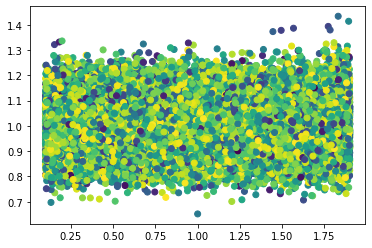

In [7]:
plt.scatter(true_alpha, torch.mean(pred_alpha,dim=-1),c=length[model_name])

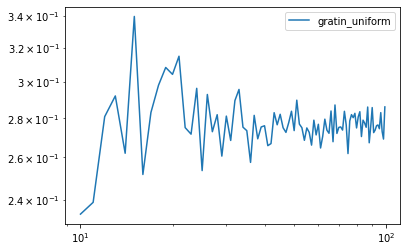

In [7]:
for name in length:
    unique_length = torch.unique(length[name])
    plt.plot(unique_length,[torch.mean(se[name][length[name]==l]) for l in unique_length],label=name)
    plt.yscale("log")
    plt.xscale("log")
    plt.legend()

In [8]:
se = {}
length = {}
for model, model_name in zip([model_lstm, model_gratin],["LSTM","Gratin"]):

    tb_logger = pl.loggers.TensorBoardLogger(
        save_dir=os.path.join(export_path, "tb_logs"),
        default_hp_metric=False,
        name=model_name,
        flush_secs=60,
        #log_graph=True,
    )

    trainer = pl.Trainer(
        gpus=1,
        detect_anomaly=True,
        logger=tb_logger,
        gradient_clip_val=1.0,
        gradient_clip_algorithm="value",
        flush_logs_every_n_steps=150,
        track_grad_norm=2,
        accumulate_grad_batches=4,
        max_epochs=10,
        callbacks=[fBMPlotter()],
        reload_dataloaders_every_n_epochs=1)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        trainer.fit(model,dm)

    res = trainer.predict(model, datamodule=dm)
    true_alpha = []
    pred_alpha = []
    length_ = []
    for pred, true, length__ in res:
        true_alpha.append(true[:,1])
        pred_alpha.append(pred[:,1])
        length_.append(length__)
    true_alpha = torch.cat(true_alpha,dim=0)
    pred_alpha = torch.cat(pred_alpha,dim=0)
    length[model_name] = torch.cat(length_,dim=0)[:,0]
    se[model_name] = (true_alpha-torch.mean(pred_alpha,dim=-1))**2

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:61: LightningDeprecationWarning: Setting `Trainer(flush_logs_every_n_steps=150)` is deprecated in v1.5 and will be removed in v1.7. Please configure flushing in the logger instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | features_maker | TrajsFeatures    | 0     
1 | encoder        | TrajsEncoderLSTM | 136 K 
2 | invertible_net | InvertibleNet    | 24.6 K
----------------------------------------------------
161 K     Trainable params
12        Non-trainable params
161 K     Total params
0.646     Total estimated model params size (MB)


Prepare datasets
Creating new train fBMTrajDataset, seed=1000000
seed_offset = 1000000
Sanity Checking: 0it [00:00, ?it/s]Validation dataloader
Prepare datasets
seed_offset = 0
Prepare datasets                                                           
Creating new train fBMTrajDataset, seed=1000000
seed_offset = 1000000
Train dataloader, epoch = 10
Epoch 0:  14%|█▍        | 116/843 [00:23<02:29,  4.87it/s, loss=-0.848, v_num=2, training_loss_step=-.908, z_norm=1.780, log_J=1.800] 

/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:351: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Prepare datasets
seed_offset = 1200000
Prepare datasets
seed_offset = 1200000
Test dataloader
Predicting DataLoader 0:  56%|█████▌    | 435/782 [00:25<00:27, 12.47it/s]    

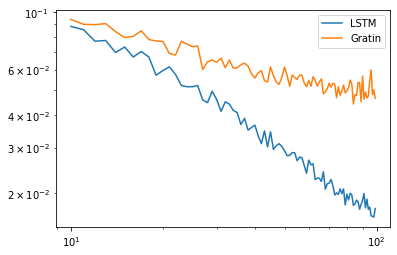

In [6]:
for name in length:
    unique_length = torch.unique(length[name])
    plt.plot(unique_length,[torch.mean(se[name][length[name]==l]) for l in unique_length],label=name)
    plt.yscale("log")
    plt.xscale("log")
    plt.legend()

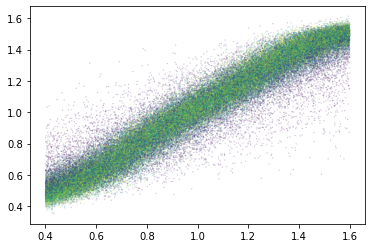

In [11]:
plt.scatter(true_alpha,torch.mean(pred_alpha,dim=-1),s=.01,c=length)

(array([ 1791., 11421., 11385., 10243., 11055., 11750., 11377., 11844.,
        13734.,  5400.]),
 array([0.34425864, 0.47072595, 0.59719324, 0.7236605 , 0.8501278 ,
        0.97659516, 1.1030624 , 1.2295297 , 1.3559971 , 1.4824643 ,
        1.6089317 ], dtype=float32),
 <BarContainer object of 10 artists>)

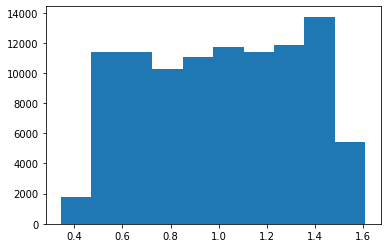

In [12]:
plt.hist(torch.median(pred_alpha,dim=-1)[0])

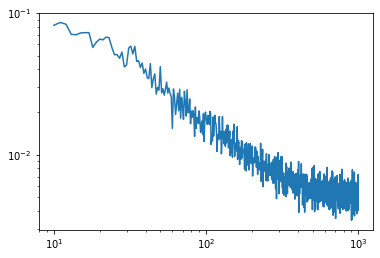

(array([10100.,  9849., 10066.,  9905.,  9974., 10112.,  9897.,  9961.,
        10080., 10056.]),
 array([ 10. , 108.9, 207.8, 306.7, 405.6, 504.5, 603.4, 702.3, 801.2,
        900.1, 999. ], dtype=float32),
 <BarContainer object of 10 artists>)

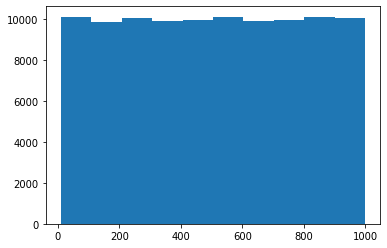

In [14]:
plt.hist(length)